In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import sys 
sys.path.append("../..")

import pykep as pk
import paseos
from paseos import ActorBuilder, SpacecraftActor, GroundstationActor
from paseos.utils.load_default_cfg import load_default_cfg
import asyncio
paseos.set_log_level("INFO")

16:50:32|PASEOS-DEBUG| Setting LogLevel to DEBUG
16:50:32|PASEOS-DEBUG| Loaded module.


In [2]:
from get_constellation import get_constellation
altitude = 400 * 1000
inclination = 40.0
nPlanes = 4
nSats = 4
t0 = pk.epoch(0)

planet_list,sats_pos_and_v = get_constellation(altitude,inclination,nSats,nPlanes,t0)
comms_sat,comm_sat_pos_and_v = get_constellation(30000*1000,0,1,1,t0)

Added 16 planets
Computing positions and velocities
Added 1 planets
Computing positions and velocities


<Axes3DSubplot:>

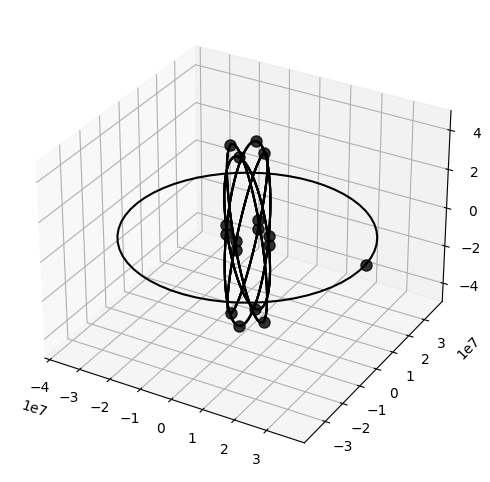

In [3]:
fig = plt.figure(figsize=(6,6),dpi=100)
ax = plt.axes(projection='3d')
for i in range (nPlanes*nSats):
    pk.orbit_plots.plot_planet(planet_list[i],axes=ax,s=64)
pk.orbit_plots.plot_planet(comms_sat[0],axes=ax,s=64)

In [4]:
paseos_instances = []
earth = pk.planet.jpl_lp("earth")
for idx,sat_pos_v in enumerate(sats_pos_and_v):
    pos,v = sat_pos_v
    sat_actor = ActorBuilder.get_actor_scaffold(name="Sat_"+str(idx),
                                                actor_type=SpacecraftActor,
                                                epoch=t0)
    ActorBuilder.set_orbit(actor=sat_actor,position=pos,velocity=v,epoch=t0,central_body=earth)
    ActorBuilder.add_comm_device(actor=sat_actor,device_name="Link1",bandwidth_in_kbps=1000)
    ActorBuilder.set_power_devices(actor=sat_actor,battery_level_in_Ws=50000,
                                   max_battery_level_in_Ws=100000,charging_rate_in_W=50)
    ActorBuilder.set_thermal_model(
            actor=sat_actor,
            actor_mass=50.0,
            actor_initial_temperature_in_K=273.15,
            actor_sun_absorptance=1.0,
            actor_infrared_absorptance=1.0,
            actor_sun_facing_area=1.0,
            actor_central_body_facing_area=1.0,
            actor_emissive_area=3.0,
            actor_thermal_capacity=1000
    )
    
    instance = paseos.init_sim(local_actor=sat_actor)
    paseos_instances.append(instance)

In [5]:
comms_instances = []

gs_actor = ActorBuilder.get_actor_scaffold(name="gs_1",actor_type=GroundstationActor, epoch=t0)
ActorBuilder.set_ground_station_location(gs_actor,latitude=30,longitude=30,elevation=0,minimum_altitude_angle=5)
instance = paseos.init_sim(local_actor=gs_actor)
comms_instances.append(instance)

pos,v = comm_sat_pos_and_v[0]
sat_actor = ActorBuilder.get_actor_scaffold(name="comms_1",actor_type=SpacecraftActor, epoch=t0)
ActorBuilder.set_orbit(actor=sat_actor,position=pos,velocity=v,epoch=t0,central_body=earth)
ActorBuilder.add_comm_device(actor=sat_actor,device_name="Link1",bandwidth_in_kbps=1000)    
instance = paseos.init_sim(local_actor=sat_actor)
comms_instances.append(instance)

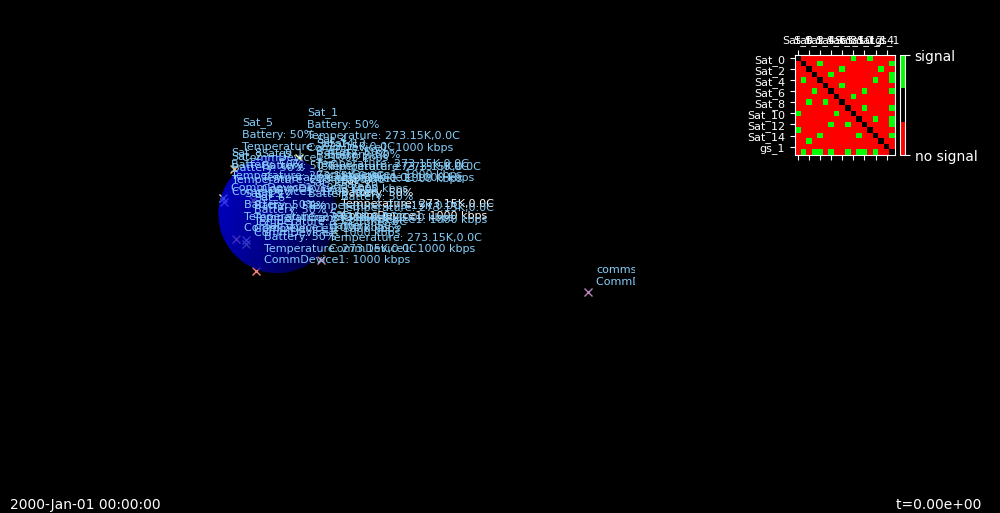

In [14]:
paseos_instances[0].emtpy_known_actors()
for instance in paseos_instances[1:]:
    paseos_instances[0].add_known_actor(instance.local_actor)
for instance in comms_instances:
    paseos_instances[0].add_known_actor(instance.local_actor)
plotter = paseos.plot(paseos_instances[0], paseos.PlotType.SpacePlot)

In [ ]:
def get_consumption_and_activity(instance):
    """Determine power consumption of the instance"""
    if operational_constraint(instance):
        return 50.0,"Processing"
    else: 
        return 2.0, "Charging"

def operational_constraint(instance):
    if (instance.local_actor.state_of_charge > 0.2 
        and instance.local_actor.temperature_in_K < 350):
        return True
    else:
        return False

In [ ]:
simulation_time = 1.0 * 3600 # one day in seconds
t = 0
timestep = 600 # 1min
while t < simulation_time: 
    # For each satellite
    N_charging = 0
    N_processing = 0
    for instance in paseos_instances:
        local_t = instance.local_actor.local_time
        # Update known actors, i.e. for each sat if they can
        # see the ground station and the comms satellite
        instance.emtpy_known_actors()
        for comm_instance in comms_instances:
            if instance.local_actor.is_in_line_of_sight(comm_instance.local_actor,epoch=local_t):
                instance.add_known_actor(comm_instance.local_actor)
        
        # Determine whether satellite is performing activity
        power_consumption, activity = get_consumption_and_activity(instance)
        if activity == "Processing":
            N_processing += 1
            eval_constraint = lambda: operational_constraint(instance)
        else:
            N_charging += 1
            eval_constraint = None
        instance.local_actor._current_activity = activity
        instance.advance_time(
            time_to_advance=timestep,
            current_power_consumption_in_W=power_consumption,
            constraint_function=eval_constraint
        )

    for instance in comms_instances:
        instance.advance_time(time_to_advance=timestep,current_power_consumption_in_W=0.0)

    print(f"Time:{t} - # of Processing = {N_processing}, # of Charging = {N_charging}")
    t += timestep

In [ ]:
def convert_known_actors_to_categorical(values):
    conv_values = []
    for val in values:
        status = ["No signal", "Ground only", "CommSat only", "Ground + Sat"]
        idx = ("comms_1" in val) * 2 + 1*("gs_1" in val)
        conv_values.append(status[idx])
    return conv_values

In [ ]:
quantities = ["temperature","state_of_charge","current_activity","known_actors"]
for item in quantities:
    names = []
    plt.figure(figsize=(8, 2),dpi=150)
    for instance in paseos_instances:
        timesteps = instance.monitor["timesteps"]
        if item == "known_actors":
            values = convert_known_actors_to_categorical(instance.monitor[item])
        else:
            values = instance.monitor[item]
        names.append(instance.local_actor.name)
        plt.plot(timesteps,values)
        plt.xlabel("Time [s]")
        plt.ylabel(item.replace("_", " "))
    # plt.legend(
    #         names,
    #         fontsize = 8,
    #         bbox_to_anchor=(0.5, 1.4),
    #         ncol=10,
    #         loc="upper center",
    # )
